<a href="https://colab.research.google.com/github/HD666g/NTHU_2023_DLBOI_HW/blob/main/HW2/HW_2_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Homework 2 Part 2: Report Part

</div>


# Step 0: Download dataset

In [ ]:
# Download Train Datasets and Test Datasets
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-10-15 14:40:58--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   346MB/s    in 0.2s    

2023-10-15 14:40:58 (346 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-15 14:40:58--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

# ✏️ Task A: Performance between BCE loss and CE loss (20 pts)

---



In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

import glob

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR, ExponentialLR

import matplotlib.pyplot as plt

from google.colab import files

## 1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


### 1-1. Training for BCE loss

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 2.2456, Train Accuracy: 75.56%, Val Loss: 0.5445, Val Accuracy: 84.75curacy_%
Epoch 2/30, Train Loss: 0.3601, Train Accuracy: 89.44%, Val Loss: 0.2023, Val Accuracy: 94.00curacy_%
Epoch 3/30, Train Loss: 0.3820, Train Accuracy: 87.94%, Val Loss: 0.2708, Val Accuracy: 91.75curacy_%
Epoch 4/30, Train Loss: 0.2202, Train Accuracy: 92.94%, Val Loss: 0.2619, Val Accuracy: 91.25curacy_%
Epoch 5/30, Train Loss: 0.1903, Train Accuracy: 93.06%, Val Loss: 0.2801, Val Accuracy: 91.00curacy_%
Epoch 6/30, Train Loss: 0.1729, Train Accuracy: 93.25%, Val Loss: 0.1829, Val Accuracy: 94.00curacy_%
Epoch 7/30, Train Loss: 0.1492, Train Accuracy: 94.62%, Val Loss: 0.2674, Val Accuracy: 92.00curacy_%
Epoch 8/30, Train Loss: 0.2062, Train Accuracy: 92.38%, Val Loss: 0.2408, Val Accuracy: 92.50curac

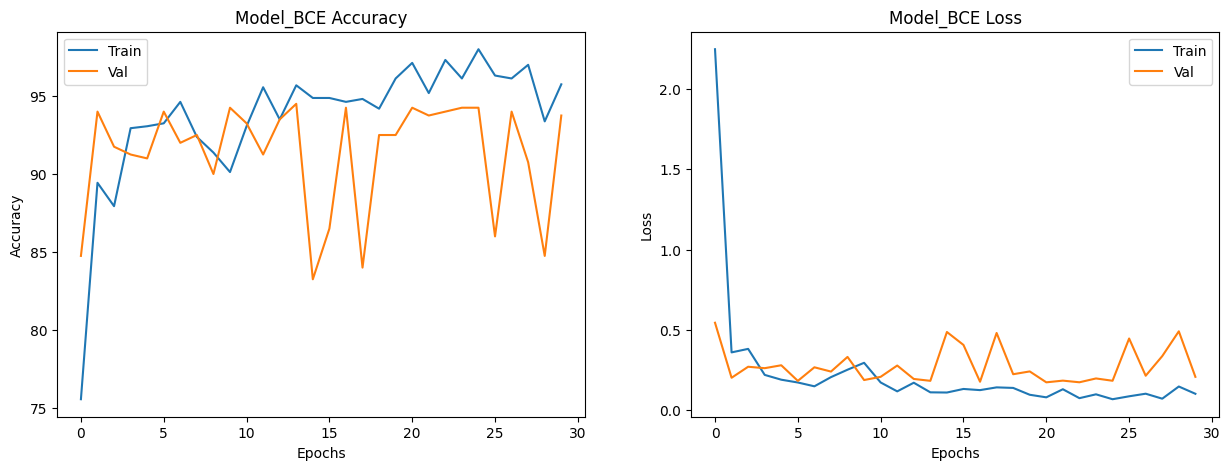

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## This first training is for BCE loss

# 2. Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
  # criterion_BCE is BCE loss; criterion_2 is CE loss
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss_BCE < best_val_loss:
        best_val_loss = avg_val_loss_BCE
        torch.save(model_BCE.state_dict(), 'model_classification_BCE.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('Model_BCE Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('Model_BCE Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('Training BCE.png')
plt.show()
files.download('Training BCE.png')

### 1-2. Training for CE loss

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=17, bias=True)
)


<ipython-input-14-07e3ba701bd4>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_val_loss = np.float('inf')


Epoch 1/30, Train Loss: 7.5664, Train Accuracy: 64.81%, Val Loss: 6.7364, Val Accuracy: 55.25curacy_%
Epoch 2/30, Train Loss: 1.4400, Train Accuracy: 84.88%, Val Loss: 0.8831, Val Accuracy: 86.50curacy_%
Epoch 3/30, Train Loss: 0.3878, Train Accuracy: 91.62%, Val Loss: 0.3539, Val Accuracy: 93.25curacy_%
Epoch 4/30, Train Loss: 0.3252, Train Accuracy: 92.38%, Val Loss: 0.5236, Val Accuracy: 88.50curacy_%
Epoch 5/30, Train Loss: 0.5762, Train Accuracy: 89.56%, Val Loss: 0.5530, Val Accuracy: 89.25curacy_%
Epoch 6/30, Train Loss: 0.3533, Train Accuracy: 92.25%, Val Loss: 0.4440, Val Accuracy: 90.75curacy_%
Epoch 7/30, Train Loss: 0.7746, Train Accuracy: 85.56%, Val Loss: 0.4472, Val Accuracy: 92.50curacy_%
Epoch 8/30, Train Loss: 0.2505, Train Accuracy: 94.56%, Val Loss: 0.3983, Val Accuracy: 92.50curacy_%
Epoch 9/30, Train Loss: 0.4702, Train Accuracy: 89.31%, Val Loss: 0.3354, Val Accuracy: 92.50curacy_%
Epoch 10/30, Train Loss: 0.2440, Train Accuracy: 94.75%, Val Loss: 0.3380, Val Acc

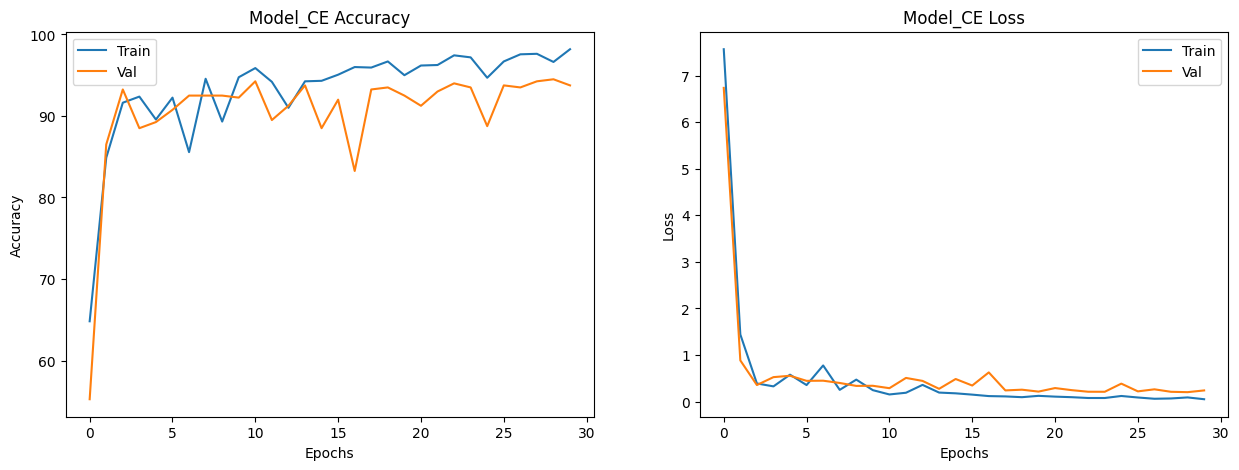

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## This second training is for CE loss

#model_CE is for CE loss
model_CE = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 17)
).cuda()

print(model_CE)

# Start training
train_losses_CE = []
val_losses_CE = []
train_accuracies_CE = []
val_accuracies_CE = []

epochs = 30
best_val_loss = np.float('inf')

criterion_CE = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in range(epochs):
    model_CE.train()
    total_loss_CE = 0.0
    train_correct_CE = 0
    total_train_samples_CE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_CE(images)

        labels = labels.long()

        loss_CE = criterion_CE(outputs, labels)
        loss_CE.backward()
        optimizer.step()
        total_loss_CE += loss_CE.item()

        train_predicted_CE = outputs.argmax(-1)
        train_correct_CE += (train_predicted_CE == labels).sum().item()
        total_train_samples_CE += labels.size(0)

    avg_train_loss_CE = total_loss_CE / len(train_loader)
    train_accuracy_CE = 100. * train_correct_CE / total_train_samples_CE

    # Validation
    model_CE.eval()

    total_val_loss_CE = 0.0
    correct_CE = 0
    total_CE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_CE(images)

            labels = labels.long()

            loss_CE = criterion_CE(outputs, labels)
            total_val_loss_CE += loss_CE.item()

            predicted_CE = outputs.argmax(-1)
            correct_CE += (predicted_CE == labels).sum().item()
            total_CE += labels.size(0)

    avg_val_loss_CE = total_val_loss_CE / len(val_loader)
    val_accuracy_CE = 100. * correct_CE / total_CE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_CE:.4f}, Train Accuracy: {train_accuracy_CE:.2f}%, Val Loss: {avg_val_loss_CE:.4f}, Val Accuracy: {val_accuracy_CE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss_CE < best_val_loss:
        best_val_loss = avg_val_loss_CE
        torch.save(model_CE.state_dict(), 'model_classification_CE.pth')

    # Store performance
    train_losses_CE.append(avg_train_loss_CE)
    train_accuracies_CE.append(train_accuracy_CE)
    val_losses_CE.append(avg_val_loss_CE)
    val_accuracies_CE.append(val_accuracy_CE)

print("2. Our model: \n\n", model_CE, '\n')
print("2. The state dict keys: \n\n", model_CE.state_dict().keys())

# Visualizing Model_CE Performance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_accuracies_CE)
ax[0].plot(val_accuracies_CE)
ax[0].set_title('Model_CE Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

ax[1].plot(train_losses_CE)
ax[1].plot(val_losses_CE)
ax[1].set_title('Model_CE Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('Training CE.png')
plt.show()
files.download('Training CE.png')

## 2. Testing Part

In [ ]:
### Testing part

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.


### 2-1. Testing for BCE loss

In [ ]:
## This first test is for BCE loss

# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('model_classification_BCE.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)
Test accuracy is 74.00%.


### 2-2. Testing for CE loss

In [ ]:
## This second test is for CE loss

#model_CE is for CE loss
model_CE = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 17)
).cuda()

print(model_CE)

# Load Training Weights
model_CE.load_state_dict(torch.load('model_classification_CE.pth'))

# Set the model to evaluation mode
model_CE.eval()

test_correct_CE = 0
test_total_CE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_CE(images)

        labels_long = labels.long()  # Convert labels to long and match shape with outputs
        predicted_CE = outputs.argmax(-1)

        test_correct_CE += (predicted_CE.float() == labels_long).sum().item()
        test_total_CE += labels.size(0)
test_accuracy_CE = 100. * test_correct_CE / test_total_CE
print(f'Test accuracy is {test_accuracy_CE:.2f}%.')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=17, bias=True)
)
Test accuracy is 71.25%.


# ✏️Task B: Performance Between Different Hyperparameters(60pts)

---

## Chosen 1: Batch Size

### Experiment No.1: Batch Size = 10

#### 1-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.4477, Train Accuracy: 79.81%, Val Loss: 0.2855, Val Accuracy: 91.50curacy_%
Epoch 2/30, Train Loss: 0.2657, Train Accuracy: 91.19%, Val Loss: 0.2094, Val Accuracy: 93.00curacy_%
Epoch 3/30, Train Loss: 0.2724, Train Accuracy: 90.12%, Val Loss: 0.1876, Val Accuracy: 93.50curacy_%
Epoch 4/30, Train Loss: 0.2382, Train Accuracy: 91.31%, Val Loss: 0.1652, Val Accuracy: 94.00curacy_%
Epoch 5/30, Train Loss: 0.2302, Train Accuracy: 91.44%, Val Loss: 0.1516, Val Accuracy

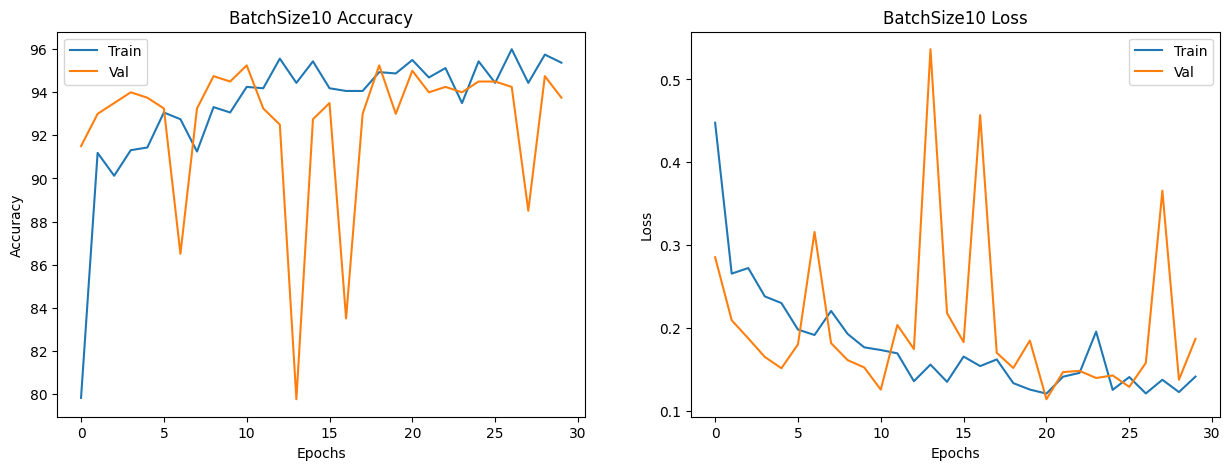

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_val_loss_BCE < best_val_loss:
     best_val_loss = avg_val_loss_BCE
     torch.save(model_BCE.state_dict(), 'Batch_Size10.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('BatchSize10 Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('BatchSize10 Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('BatchSize10.png')
plt.show()
files.download('BatchSize10.png')

#### 1-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 10.
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('Batch_Size10.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 73.00%.


### Experiment No.2: Batch size = 50


#### 2-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.4649, Train Accuracy: 81.50%, Val Loss: 0.3269, Val Accuracy: 89.25curacy_%
Epoch 2/30, Train Loss: 0.3025, Train Accuracy: 90.56%, Val Loss: 0.2235, Val Accuracy: 93.25curacy_%
Epoch 3/30, Train Loss: 0.2343, Train Accuracy: 92.31%, Val Loss: 0.2103, Val Accuracy: 93.50curacy_%
Epoch 4/30, Train Loss: 0.1769, Train Accuracy: 94.44%, Val Loss: 0.1679, Val Accuracy: 93.75curacy_%
Epoch 5/30, Train Loss: 0.1522, Train Accuracy: 95.19%, Val Loss: 0.2363, Val Accuracy

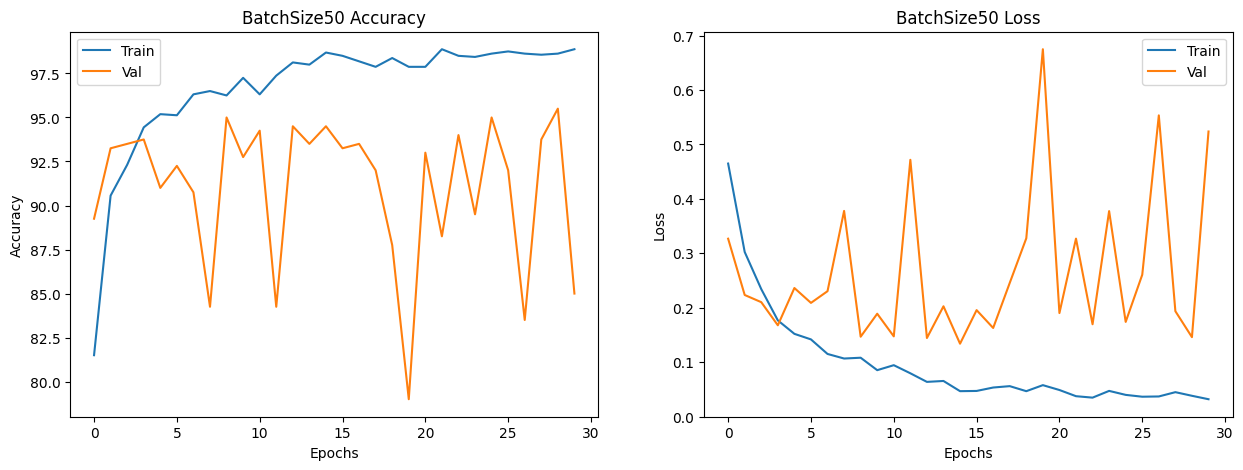

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_val_loss_BCE < best_val_loss:
      best_val_loss = avg_val_loss_BCE
      torch.save(model_BCE.state_dict(), 'Batch_Size50.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('BatchSize50 Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('BatchSize50 Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('BatchSize50.png')
plt.show()
files.download('BatchSize50.png')

#### 2-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 50.
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')
# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('Batch_Size50.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 73.75%.


### Experiment No.3: Batch Size = 100

#### 3-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.5430, Train Accuracy: 75.94%, Val Loss: 0.4556, Val Accuracy: 84.75curacy_%
Epoch 2/30, Train Loss: 0.4007, Train Accuracy: 86.38%, Val Loss: 0.3109, Val Accuracy: 90.25curacy_%
Epoch 3/30, Train Loss: 0.3252, Train Accuracy: 89.81%, Val Loss: 0.2530, Val Accuracy: 92.50curacy_%
Epoch 4/30, Train Loss: 0.2739, Train Accuracy: 90.88%, Val Loss: 0.2273, Val Accuracy: 93.00curacy_%
Epoch 5/30, Train Loss: 0.2271, Train Accuracy: 93.19%, Val Loss: 0.1957, Val Accuracy

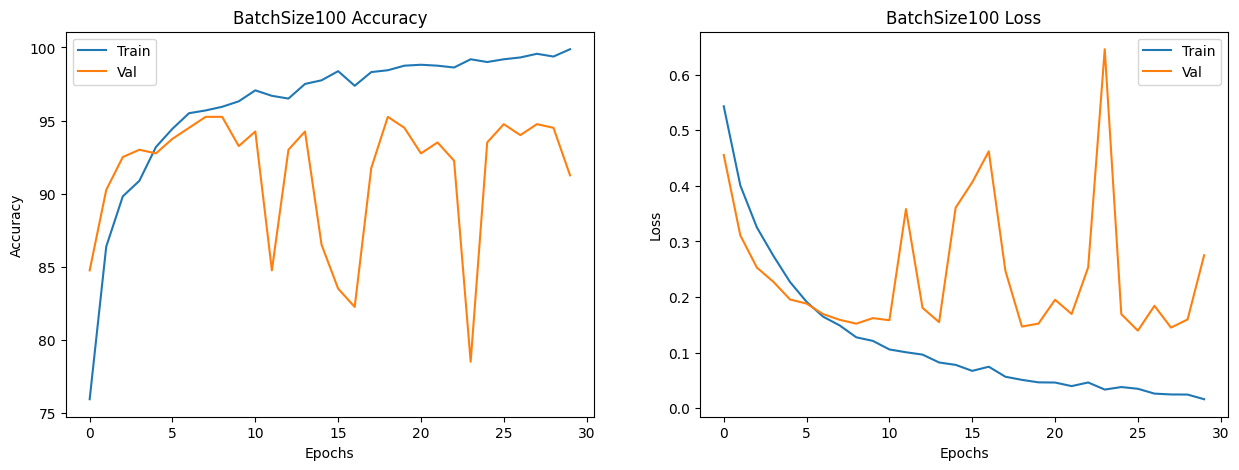

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_val_loss_BCE < best_val_loss:
      best_val_loss = avg_val_loss_BCE
      torch.save(model_BCE.state_dict(), 'Batch_Size100.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('BatchSize100 Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('BatchSize100 Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('BatchSize100.png')
plt.show()
files.download('BatchSize100.png')

#### 3-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 100.
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')
# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('Batch_Size100.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 78.50%.


## Chosen 2: Learning Rate Scheduler

### Experiment No.4: Cosine Annealing LR

#### 4-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.4663, Train Accuracy: 81.06%, Val Loss: 0.3392, Val Accuracy: 86.75curacy_%
Epoch 2/30, Train Loss: 0.2844, Train Accuracy: 90.44%, Val Loss: 0.4806, Val Accuracy: 77.00curacy_%
Epoch 3/30, Train Loss: 0.2228, Train Accuracy: 92.69%, Val Loss: 0.4413, Val Accuracy: 80.25curacy_%
Epoch 4/30, Train Loss: 0.1974, Train Accuracy: 92.88%, Val Loss: 0.2366, Val Accuracy: 91.75curacy_%
Epoch 5/30, Train Loss: 0.1398, Train Accuracy: 95.00%, Val Loss: 0.1828, Val Accuracy

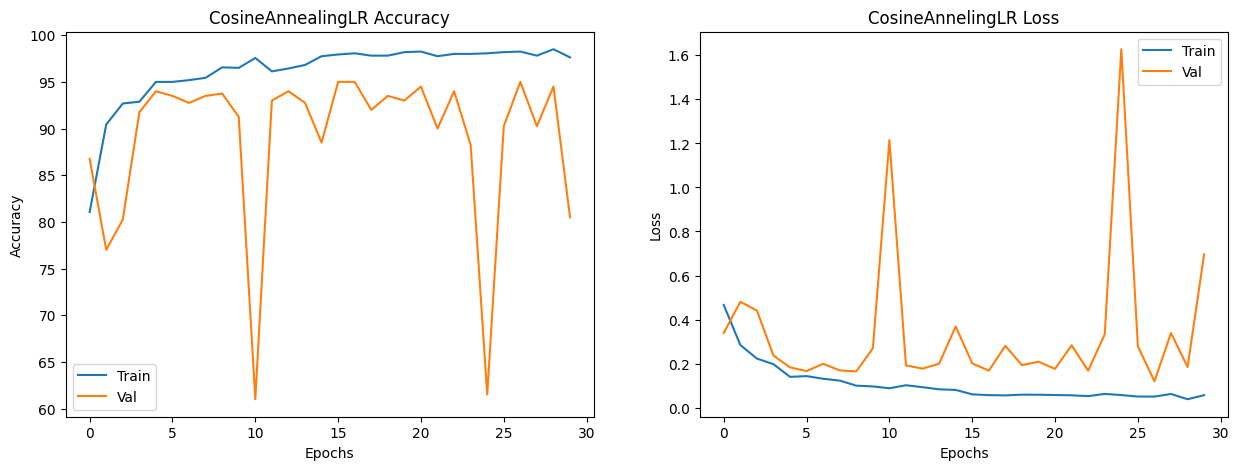

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64,1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_val_loss_BCE < best_val_loss:
      best_val_loss = avg_val_loss_BCE
      torch.save(model_BCE.state_dict(),'CosineAnnealingLR.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('CosineAnnealingLR Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('CosineAnnelingLR Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('CosineAnnealingLR.png')
plt.show()
files.download('CosineAnnealingLR.png')

#### 4-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 10.
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('CosineAnnealingLR.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 76.25%.


### Experiment No.5: OneCycleLR

#### 5-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.4487, Train Accuracy: 81.25%, Val Loss: 0.3360, Val Accuracy: 84.25curacy_%
Epoch 2/30, Train Loss: 0.3788, Train Accuracy: 83.12%, Val Loss: 0.2835, Val Accuracy: 90.00curacy_%
Epoch 3/30, Train Loss: 0.3568, Train Accuracy: 84.75%, Val Loss: 0.2625, Val Accuracy: 90.75curacy_%
Epoch 4/30, Train Loss: 0.2953, Train Accuracy: 87.75%, Val Loss: 0.2413, Val Accuracy: 91.50curacy_%
Epoch 5/30, Train Loss: 0.2874, Train Accuracy: 88.19%, Val Loss: 0.2442, Val Accuracy

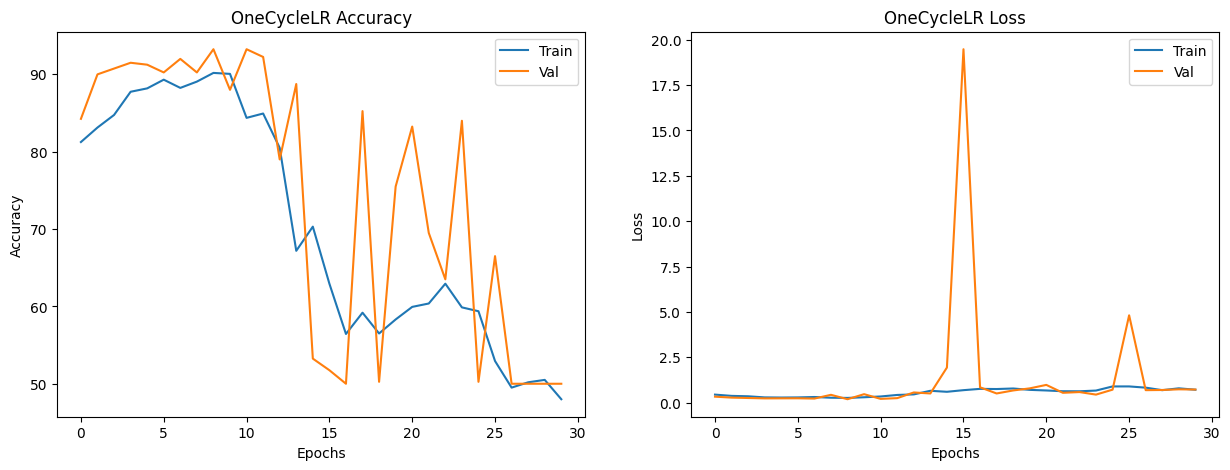

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = OneCycleLR(optimizer, max_lr=0.9, total_steps=100)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_train_loss_BCE < best_val_loss:
      best_val_loss = avg_train_loss_BCE
      torch.save(model_BCE.state_dict(), 'OneCycleLR.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('OneCycleLR Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('OneCycleLR Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('OneCycleLR.png')
plt.show()
files.download('OneCycleLR.png')

#### 5-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 10.
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('OneCycleLR.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 78.75%.


### Experiment No.6: ExponentialLR

#### 6-1.Training Part

In [ ]:
### Training Part

# 1. Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/30, Train Loss: 0.5101, Train Accuracy: 75.06%, Val Loss: 0.3195, Val Accuracy: 91.00curacy_%
Epoch 2/30, Train Loss: 0.3231, Train Accuracy: 89.19%, Val Loss: 0.2401, Val Accuracy: 93.25curacy_%
Epoch 3/30, Train Loss: 0.2445, Train Accuracy: 92.56%, Val Loss: 0.2376, Val Accuracy: 93.75curacy_%
Epoch 4/30, Train Loss: 0.1835, Train Accuracy: 93.81%, Val Loss: 0.1757, Val Accuracy: 94.50curacy_%
Epoch 5/30, Train Loss: 0.1645, Train Accuracy: 95.25%, Val Loss: 0.1715, Val Accuracy

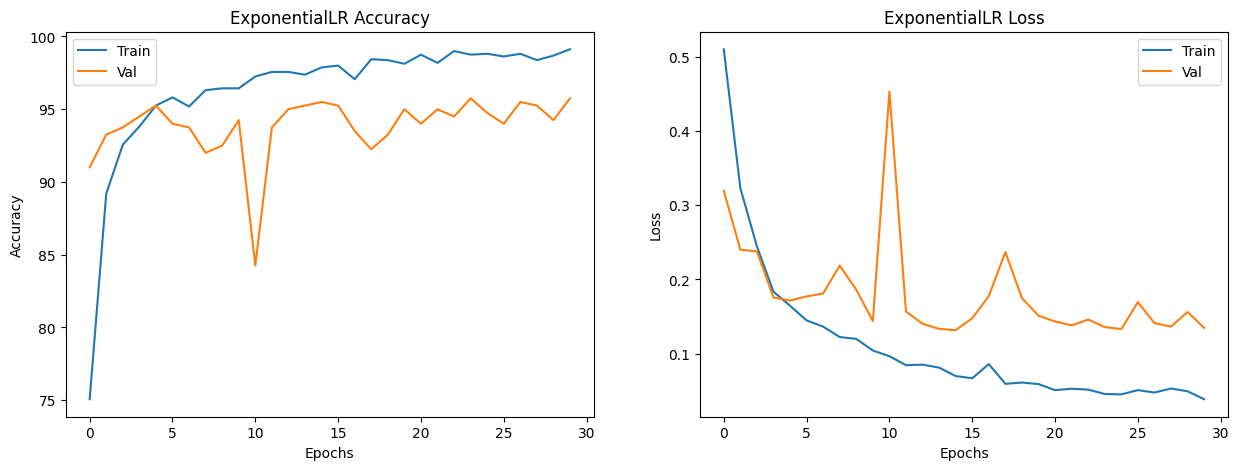

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Declare the model architecture
  # model_BCE is the model for BCE loss
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

#3. Start Training
print(model_BCE)

train_losses_BCE = []
val_losses_BCE = []
train_accuracies_BCE = []
val_accuracies_BCE = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion_BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_BCE.parameters(), lr=1e-3)
lr_scheduler = ExponentialLR(optimizer, gamma = 0.9)

for epoch in range(epochs):
    # Training

    model_BCE.train()
    total_loss_BCE = 0.0
    train_correct_BCE = 0
    total_train_samples_BCE = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model_BCE(images)

        labels = labels.float().unsqueeze(1)

        loss_BCE = criterion_BCE(outputs, labels)
        loss_BCE.backward()
        optimizer.step()
        total_loss_BCE += loss_BCE.item()

        train_predicted_BCE = torch.sigmoid(outputs) > 0.5
        train_correct_BCE += (train_predicted_BCE.float() == labels).sum().item()
        total_train_samples_BCE += labels.size(0)

    avg_train_loss_BCE = total_loss_BCE / len(train_loader)
    train_accuracy_BCE = 100. * train_correct_BCE / total_train_samples_BCE

    # Validation
    model_BCE.eval()
    total_val_loss_BCE = 0.0
    correct_BCE = 0
    total_BCE = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model_BCE(images)

            labels = labels.float().unsqueeze(1)

            loss_BCE = criterion_BCE(outputs, labels)
            total_val_loss_BCE += loss_BCE.item()

            predicted_BCE = torch.sigmoid(outputs) > 0.5
            correct_BCE += (predicted_BCE.float() == labels).sum().item()
            total_BCE += labels.size(0)

    avg_val_loss_BCE = total_val_loss_BCE / len(val_loader)
    val_accuracy_BCE = 100. * correct_BCE / total_BCE

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_BCE:.4f}, Train Accuracy: {train_accuracy_BCE:.2f}%, Val Loss: {avg_val_loss_BCE:.4f}, Val Accuracy: {val_accuracy_BCE:.2f}curacy_%')

    # Learning rate update
    lr_scheduler.step()

    # Store Training Weights
    if avg_val_loss_BCE < best_val_loss:
      best_val_loss = avg_val_loss_BCE
      torch.save(model_BCE.state_dict(), 'ExponentialLR.pth')

    # Store performance
    train_losses_BCE.append(avg_train_loss_BCE)
    train_accuracies_BCE.append(train_accuracy_BCE)
    val_losses_BCE.append(avg_val_loss_BCE)
    val_accuracies_BCE.append(val_accuracy_BCE)

print(f"1. Our model: \n\n", model_BCE, '\n')
print(f"1. The state dict keys: \n\n", model_BCE.state_dict().keys())

# 4. Visualizing Model_BCE Perfromance
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies_BCE)
ax[0].plot(val_accuracies_BCE)
ax[0].set_title('ExponentialLR Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses_BCE)
ax[1].plot(val_losses_BCE)
ax[1].set_title('ExponentialLR Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.savefig('ExponentialLR.png')
plt.show()
files.download('ExponentialLR.png')

#### 6-2. Testing Part

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).long()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 10.
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

print(f'Number of samples in train is {len(test_loader.dataset)}.')
print(f'X_train: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

# Declare the model architecture
model_BCE = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

print(model_BCE)

# Load Training Weights
model_BCE.load_state_dict(torch.load('ExponentialLR.pth'))

# Set the model to evaluation mode
model_BCE.eval()

test_correct_BCE = 0
test_total_BCE = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255

        labels = labels.cuda()

        outputs = model_BCE(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted_BCE = torch.sigmoid(outputs) > 0.5

        test_correct_BCE += (predicted_BCE.float() == labels_float).sum().item()
        test_total_BCE += labels.size(0)
test_accuracy_BCE = 100. * test_correct_BCE / test_total_BCE
print(f'Test accuracy is {test_accuracy_BCE:.2f}%.')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
Number of samples in train is 400.
X_train: max value is 255, min value is 0, data type is torch.int64.
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Test accuracy is 73.50%.
